In [ ]:
! pip install wordcloud

   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   ------------ --------------------------- 92.2/301.2 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------  297.0/301.2 kB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 301.2/301.2 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from collections import Counter
from wordcloud import WordCloud

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
df = pd.read_excel("data_imdb.xlsx")  # Update with correct path

# Data Exploration
print(df.head())
print(df.info())
df['sentiment'].value_counts()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajami\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ajami\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ajami\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [39]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Optimized function to clean and preprocess text"""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"<br\s*/?>", " ", text)  # Remove <br> tags
    text = re.sub(r"\bbr\b", " ", text)  # Remove standalone 'br'
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = regexp_tokenize(text, pattern=r'\s+', gaps=True)  # Tokenization using regex
    tokens = (lemmatizer.lemmatize(word) for word in tokens if word not in stop_words)  # Stopword removal + Lemmatization
    return " ".join(tokens)


# Apply preprocessing
df['cleaned_text'] = df['review'].apply(preprocess_text)

In [41]:
# Feature Engineering
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['sentiment'].map({'positive': 1, 'negative': 0})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression Accuracy: 0.8858
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



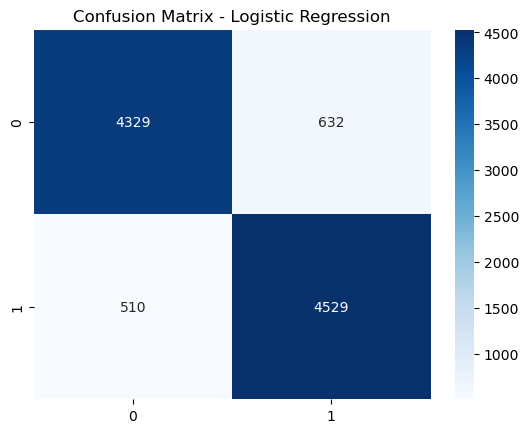

Logistic Regression ROC-AUC Score: 0.9577


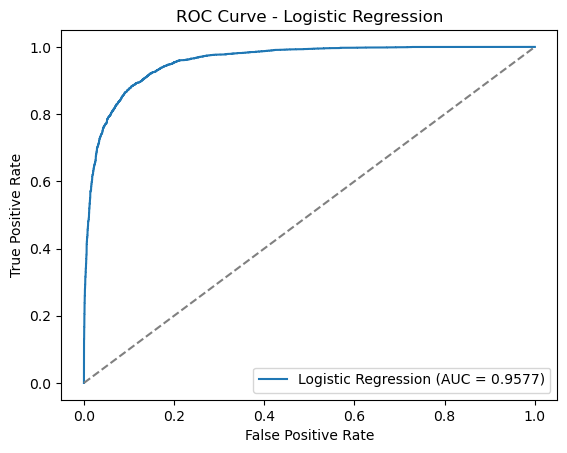

Naive Bayes Accuracy: 0.8534
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



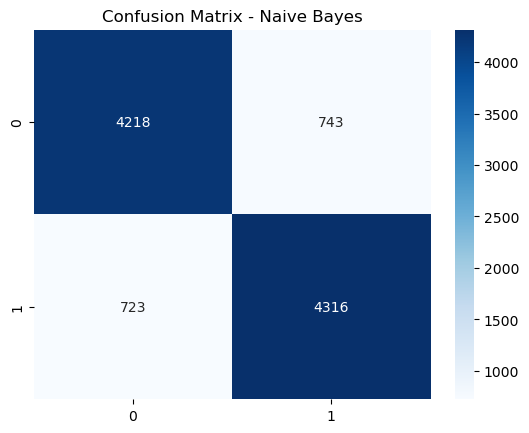

Naive Bayes ROC-AUC Score: 0.9290


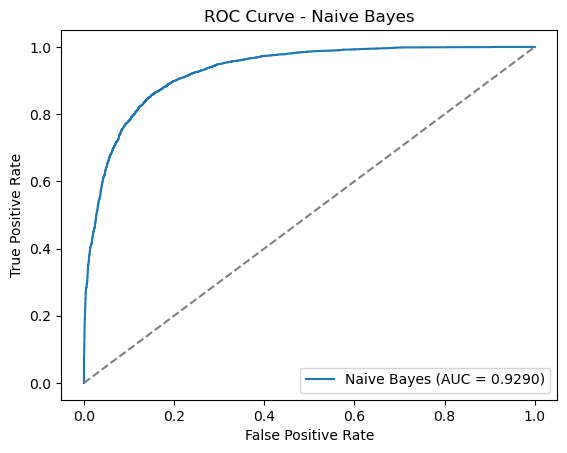

In [43]:
# Model Training and Evaluation
def train_and_evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    print(f"{model_name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"{model_name} ROC-AUC Score: {roc_auc:.4f}")
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    
}

for name, model in models.items():
    train_and_evaluate_model(model, name)

Random Forest Accuracy: 0.8513
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      4961
           1       0.86      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



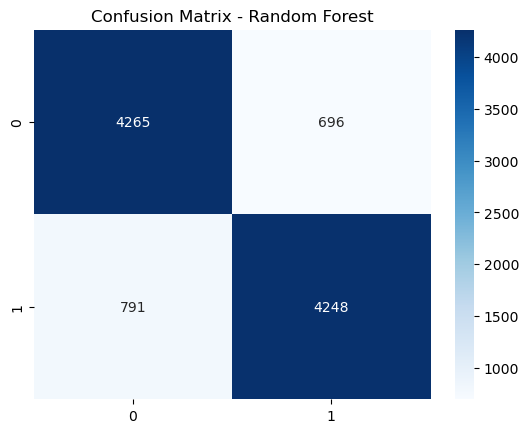

Random Forest ROC-AUC Score: 0.9309


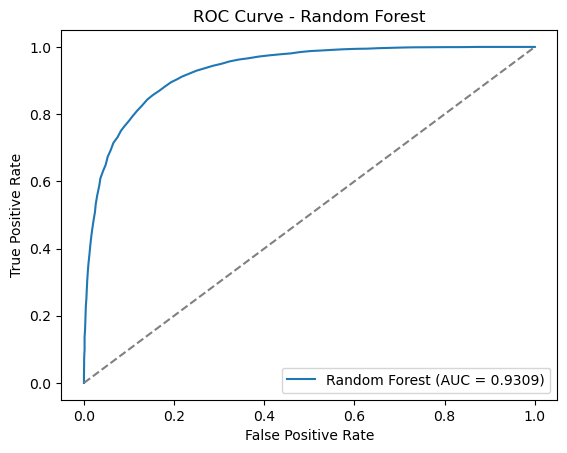

In [9]:
# Model Training and Evaluation for random forest
def train_and_evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probability scores for ROC-AUC

    # Print Metrics
    print(f"{model_name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"{model_name} ROC-AUC Score: {roc_auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)   
}

for name, model in models.items():
    train_and_evaluate_model(model, name)

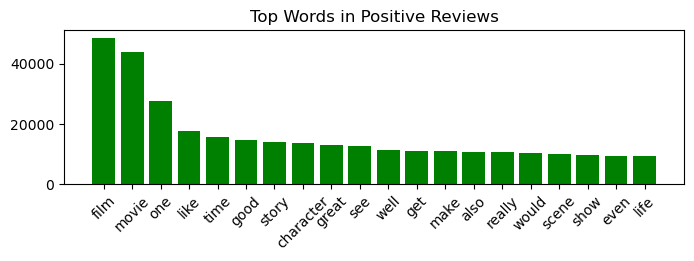

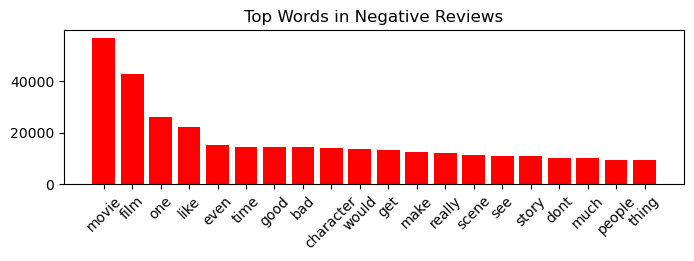

In [45]:
# Sentiment Analysis Insights
# Word Frequency Analysis
positive_reviews = " ".join(df[df['sentiment'] == 'positive']['cleaned_text'])
negative_reviews = " ".join(df[df['sentiment'] == 'negative']['cleaned_text'])

positive_words = Counter(positive_reviews.split()).most_common(20)
negative_words = Counter(negative_reviews.split()).most_common(20)

plt.figure(figsize=(8, 2))
plt.bar(*zip(*positive_words), color='green')
plt.xticks(rotation=45)
plt.title("Top Words in Positive Reviews")
plt.show()

plt.figure(figsize=(8, 2))
plt.bar(*zip(*negative_words), color='red')
plt.xticks(rotation=45)
plt.title("Top Words in Negative Reviews")
plt.show()

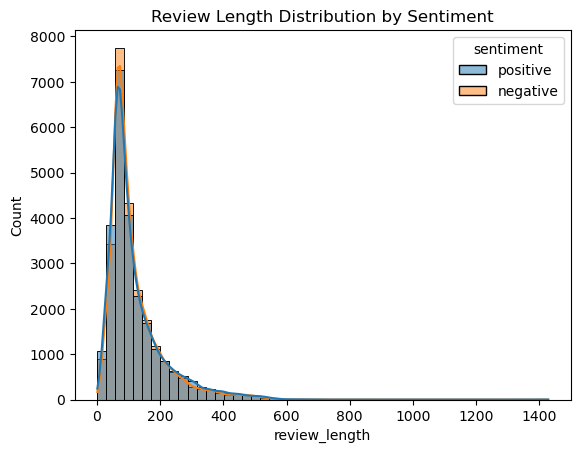

In [47]:
# Review Length Analysis
df['review_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='review_length', hue='sentiment', bins=50, kde=True)
plt.title("Review Length Distribution by Sentiment")
plt.show()

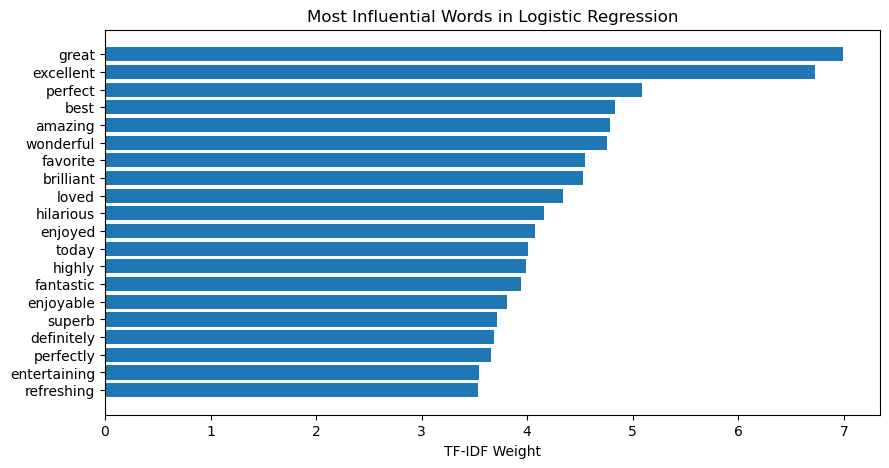

In [49]:
# TF-IDF Weight Distribution for Logistics Regression 
feature_names = vectorizer.get_feature_names_out()
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
logreg_coeffs = lr_model.coef_.flatten()
top_tfidf_indices = np.argsort(logreg_coeffs)[-20:]
plt.figure(figsize=(10, 5))
plt.barh(np.array(feature_names)[top_tfidf_indices], logreg_coeffs[top_tfidf_indices])
plt.xlabel("TF-IDF Weight")
plt.title("Most Influential Words in Logistic Regression")
plt.show()

After observing the results of the 3 algorithms that I tried, I found out that:

- Logistic regression has better accuracy, precision, recall, f1-score and ROC-AUC score than the rest of the algorithm.
- So, the TDF-IDF weight distribution was based on Logistic regression scores.
- Also the SVM algorithm taking too long to execute, so after trying it many times, I decided not to include it.
